# It's Corn (PogChamps \#3) Kaggle Competition - Experiment 7
## Model Error Analysis on Models from Experiment \#6

Attempting to load trained models from experiment \#5 and do some simple model analysis to see if any insights can be made based on the type/quantity of errors.

## Setup Competition Files

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [2]:
comp = 'kaggle-pog-series-s01e03'

In [3]:
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [4]:
import timm
from fastai.vision.all import *
set_seed(42)

# path.ls()

In [5]:
csv_path = path/'corn'

In [6]:
trn_path = csv_path/'train'
# trn_path.ls()

In [7]:
tst_path = csv_path/'test'
# tst_path.ls()

Grab csv lists

In [8]:
csv_path = path/'corn'
train_csv_fname = csv_path/'train.csv'
trn_files = pd.read_csv(train_csv_fname)
test_csv_fname = csv_path/'test.csv'
tst_files = pd.read_csv(test_csv_fname)
ss_csv_fname = csv_path/'sample_submission.csv'
ss = pd.read_csv(ss_csv_fname)

Re-enumerate options tested in experiment 6

In [9]:
champ_augmentations = {
    'flip_rotate256': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smcrop256': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smlightcropwarp256': aug_transforms(size=(256,256),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate224': aug_transforms(size=(224,224),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smcrop224': aug_transforms(size=(224,224),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smlightcropwarp224': aug_transforms(size=(224,224),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate192': aug_transforms(size=(192,192),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.0,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=1.0,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smcrop192': aug_transforms(size=(192,192),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
    'flip_rotate_smlightcropwarp192': aug_transforms(size=(192,192),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border'),
}

In [10]:
models = {
    'convnext_large_in22k': {
        ('flip_rotate256', 11),
        ('flip_rotate_smcrop256', 21),
        ('flip_rotate_smlightcropwarp256', 31),
    }, 'vit_large_patch16_224': {
        ('flip_rotate224', 42),
        ('flip_rotate_smcrop224', 52),
        ('flip_rotate_smlightcropwarp224', 62),
    }, 'swinv2_large_window12_192_22k': {
        ('flip_rotate192', 73),
        ('flip_rotate_smcrop192', 83),
        ('flip_rotate_smlightcropwarp192', 93),
    }, 'swin_large_patch4_window7_224': {
        ('flip_rotate224', 14),
        ('flip_rotate_smcrop224', 24),
        ('flip_rotate_smlightcropwarp224', 34),
    }
}

Generate confusion matrices for models trained in experiment 6

In [28]:
import gc

_item = Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border)
_epochs = 12

tta_res = []
valid_res = []
tta_valid_res = []

for _arch, details in models.items():
    for _batch, _seed in details:
        print('---',_arch," ",_batch," ",_seed,'---')
        
        # Load Model
        model_filename = f'{_arch}-{_batch}-seed_{_seed}-epochs_{_epochs}-expt_6.pkl'
        learn = load_learner(csv_path/model_filename).to_fp16()
        
        # Provide identical dataloader
        dls = ImageDataLoaders.from_df(trn_files, seed=_seed,
            path=csv_path, fn_col=2, label_col=3,
            valid_pct=0.2, item_tfms=_item,
            batch_tfms=champ_augmentations[_batch],
            bs=64//2)
        learn.dls = dls
          
#         learn, tta_out = train_accum(arch, batch=champ_augmentations[batch], item=_item, accum=2, finetune=True, epochs=_epochs, new_seed=seed)
#         tta_res.append(tta_out)
        
        # Verify stats on validation set
        valid = learn.dls.valid
        preds,targs = learn.get_preds(dl=valid)
        valid_res.append(accuracy(preds,targs))
        
        # Check TTA statistics on validation set
#         tta_preds,targs = learn.tta(dl=valid)
#         tta_valid_res.append(accuracy(tta_preds,targs))

        # Attempt to clear GPU memory (as best we can)
        del(learn)
        print(torch.cuda.list_gpu_processes())
        gc.collect()
        torch.cuda.empty_cache()

--- convnext_large_in22k   flip_rotate_smlightcropwarp256   31 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     4849.000 MB GPU memory
--- convnext_large_in22k   flip_rotate256   11 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     4859.000 MB GPU memory
--- convnext_large_in22k   flip_rotate_smcrop256   21 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     4859.000 MB GPU memory
--- vit_large_patch16_224   flip_rotate_smcrop224   52 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5105.000 MB GPU memory
--- vit_large_patch16_224   flip_rotate_smlightcropwarp224   62 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5105.000 MB GPU memory
--- vit_large_patch16_224   flip_rotate224   42 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5105.000 MB GPU memory
--- swinv2_large_window12_192_22k   flip_rotate_smcrop192   83 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     4853.000 MB GPU memory
--- swinv2_large_window12_192_22k   flip_rotate192   73 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     4853.000 MB GPU memory
--- swinv2_large_window12_192_22k   flip_rotate_smlightcropwarp192   93 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     4853.000 MB GPU memory
--- swin_large_patch4_window7_224   flip_rotate_smcrop224   24 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     4879.000 MB GPU memory
--- swin_large_patch4_window7_224   flip_rotate_smlightcropwarp224   34 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     4879.000 MB GPU memory
--- swin_large_patch4_window7_224   flip_rotate224   14 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     4879.000 MB GPU memory


Runs from experiment 6

```
[TensorBase(0.7999), TensorBase(0.8080), TensorBase(0.8052), TensorBase(0.7839), TensorBase(0.7957), TensorBase(0.8118), TensorBase(0.8083), TensorBase(0.8017), TensorBase(0.8020), TensorBase(0.7996), TensorBase(0.8083), TensorBase(0.8233)]
[TensorBase(0.8059), TensorBase(0.8135), TensorBase(0.8160), TensorBase(0.7867), TensorBase(0.8128), TensorBase(0.8142), TensorBase(0.8139), TensorBase(0.8059), TensorBase(0.8146), TensorBase(0.8059), TensorBase(0.8163), TensorBase(0.8240)]
```

In [29]:
print(valid_res)
# print(tta_valid_res)

[TensorBase(0.7291), TensorBase(0.6973), TensorBase(0.7057), TensorBase(0.7552), TensorBase(0.7699), TensorBase(0.7245), TensorBase(0.7105), TensorBase(0.6882), TensorBase(0.7287), TensorBase(0.6927), TensorBase(0.7413), TensorBase(0.7001)]


For some reason I cannot get the dataloader to reproduce the train/valid split (even providing the seed).  I assume this is what is causing the differences as the simple validation accuracy is not reproducable.  Unfortunately, this prohibits doing much model error analysis without including images regardless of train/val set identity during training.

For fun, let's see what happens if we plot the confusion matrices for the models for all train data.

--- convnext_large_in22k   flip_rotate_smlightcropwarp256   31 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5063.000 MB GPU memory
--- convnext_large_in22k   flip_rotate256   11 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5505.000 MB GPU memory
--- convnext_large_in22k   flip_rotate_smcrop256   21 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5299.000 MB GPU memory
--- vit_large_patch16_224   flip_rotate_smcrop224   52 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5561.000 MB GPU memory
--- vit_large_patch16_224   flip_rotate_smlightcropwarp224   62 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5929.000 MB GPU memory
--- vit_large_patch16_224   flip_rotate224   42 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5917.000 MB GPU memory
--- swinv2_large_window12_192_22k   flip_rotate_smcrop192   83 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5647.000 MB GPU memory
--- swinv2_large_window12_192_22k   flip_rotate192   73 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5301.000 MB GPU memory
--- swinv2_large_window12_192_22k   flip_rotate_smlightcropwarp192   93 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5301.000 MB GPU memory
--- swin_large_patch4_window7_224   flip_rotate_smcrop224   24 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5305.000 MB GPU memory
--- swin_large_patch4_window7_224   flip_rotate_smlightcropwarp224   34 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5301.000 MB GPU memory
--- swin_large_patch4_window7_224   flip_rotate224   14 ---


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     754977 uses     5301.000 MB GPU memory


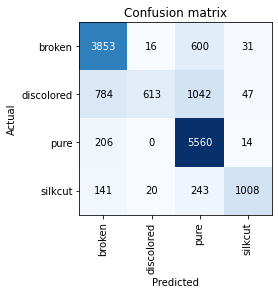

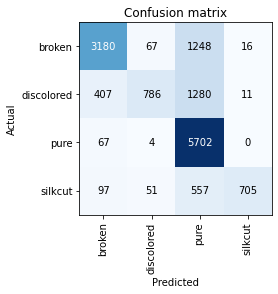

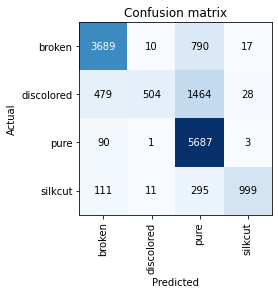

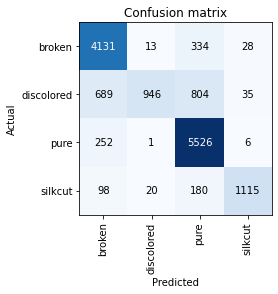

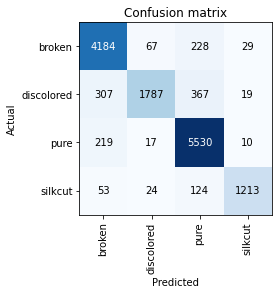

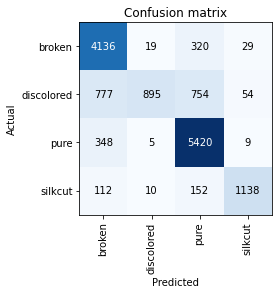

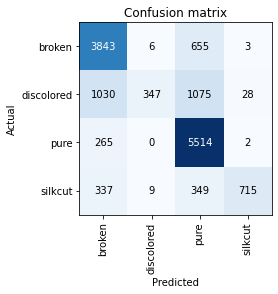

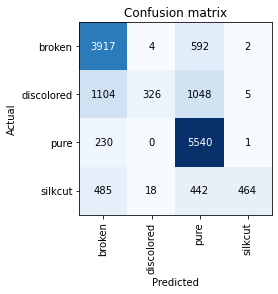

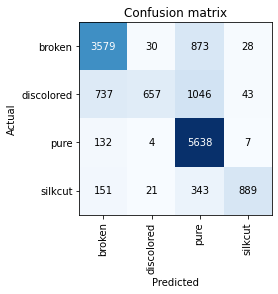

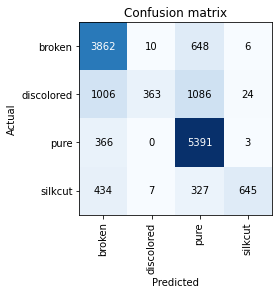

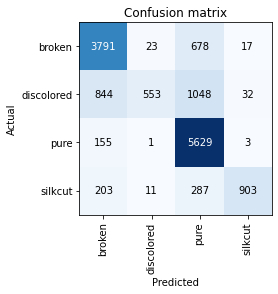

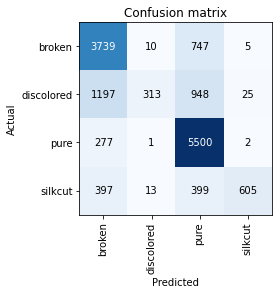

In [37]:
import gc

_item = Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border)
_epochs = 12

for _arch, details in models.items():
    for _batch, _seed in details:
        print('---',_arch," ",_batch," ",_seed,'---')
        
        # Load Model
        model_filename = f'{_arch}-{_batch}-seed_{_seed}-epochs_{_epochs}-expt_6.pkl'
        learn = load_learner(csv_path/model_filename).to_fp16()
        
        # Provide dataloader with (almost) no train set (otherwise identical)
        dls = ImageDataLoaders.from_df(trn_files, seed=_seed,
            path=csv_path, fn_col=2, label_col=3,
            valid_pct=0.99, item_tfms=_item,
            batch_tfms=champ_augmentations[_batch],
            bs=64//2)
        learn.dls = dls
          
        interp = ClassificationInterpretation.from_learner(learn)
        interp.plot_confusion_matrix()

        # Attempt to clear GPU memory (as best we can)
        del(learn)
        print(torch.cuda.list_gpu_processes())
        gc.collect()
        torch.cuda.empty_cache()

As expected the classes most represented in the training data is over represented in the predictions.  Many of the models get a disproportionate number of their incorrect predictions confusing discolored corn and predicting broken or pure instead.  The model that seemed to do the best in this regard was `vit_large_patch16_224   flip_rotate_smlightcropwarp22`.

## Submission
Out of curiousity, let's try submitting results solely from that model.

Set parameters and load the model.

In [44]:
_item = Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border)
_epochs = 12
_arch = 'vit_large_patch16_224'
_batch = 'flip_rotate_smlightcropwarp224'
_seed = 62

# Load Model
model_filename = f'{_arch}-{_batch}-seed_{_seed}-epochs_{_epochs}-expt_6.pkl'
learn = load_learner(csv_path/model_filename, cpu=False).to_fp16()

print(model_filename)

vit_large_patch16_224-flip_rotate_smlightcropwarp224-seed_62-epochs_12-expt_6.pkl


Grab test files.

In [45]:
# Grab test files
tst_files = get_image_files(tst_path).sorted()
tst_dl = dls.test_dl(tst_files)

Get predictions from the model on the test data.

In [46]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([0, 2, 2,  ..., 2, 2, 2])

Grab the `vocab` from a model dataloader

In [49]:
# Provide dataloader trying to be same parameters as training dataloader
dls = ImageDataLoaders.from_df(trn_files, seed=_seed,
    path=csv_path, fn_col=2, label_col=3,
    valid_pct=0.2, item_tfms=_item,
    batch_tfms=champ_augmentations[_batch],
    bs=64//2)

vocab = np.array(dls.vocab)
vocab

array(['broken', 'discolored', 'pure', 'silkcut'], dtype='<U10')

Map prediction indexes to vocab list.

In [50]:
results = pd.Series(vocab[idxs], name="idxs")
results

0           broken
1             pure
2             pure
3           broken
4           broken
           ...    
3474    discolored
3475          pure
3476          pure
3477          pure
3478          pure
Name: idxs, Length: 3479, dtype: object

Modify the test file to a submission csv

In [52]:
test_csv_fname = csv_path/'test.csv'
test = pd.read_csv(test_csv_fname)
test.head()

,seed_id,view,image
0,2,top,test/00002.png
1,11,bottom,test/00011.png
2,13,top,test/00013.png
3,19,bottom,test/00019.png
4,27,bottom,test/00027.png


In [53]:
test.sort_values(by=['seed_id'])
test = test.drop(columns=['view', 'image'])
test['label'] = results
test

,seed_id,label
0,2,broken
1,11,pure
2,13,pure
3,19,broken
4,27,broken
...,...,...
3474,17775,discolored
3475,17781,pure
3476,17790,pure
3477,17794,pure


In [54]:
test.to_csv('submission_experiment_7.csv', index=False)
!head submission_experiment_7.csv

seed_id,label
2,broken
11,pure
13,pure
19,broken
27,broken
30,pure
32,pure
41,pure
42,broken


Let's submit!

In [55]:
# if not iskaggle:
#     from kaggle import api
#     api.competition_submit_cli('submission_experiment_7.csv', 'vit_large_patch16_224-flip_rotate_smlightcropwarp224-seed_62-epochs_12-expt_6/7', comp)

100%|██████████████████████████████████████| 40.8k/40.8k [00:00<00:00, 51.4kB/s]


Single model score had accuracy of 77.729% on public leaderboard.